In [3]:
import tensorflow as tf
import keras
from keras.applications import InceptionV3, MobileNetV2
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.layers import Convolution2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, Lambda
import matplotlib.pyplot as plt
import pickle
from keras.models import load_model
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.inception_v3 import preprocess_input
#from tensorflow.keras.applications.MobileNet import preprocess_input
import numpy as np

In [4]:
#The dataset is obtained from the following google drive link
#https://drive.google.com/drive/folders/1Si9hduU-WYC63p91C2SJVUKZ3IPtsdJm?usp=sharing

In [5]:
#The links to the google drive directory
train = '/content/drive/My Drive/data/train'
valid = '/content/drive/My Drive/data/val'
test = '/content/drive/My Drive/data/test'

In [6]:
#Define the image size
image_size = [224,224]

In [7]:
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)


# add preprocessing layer to the front of mobilenet. We can remove the top and last layer of Mobilenetv2 model as we don't train them. 
conv_base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

#No need to retrain the model since we directly use the imagenet weights
conv_base.trainable = False
conv_base.summary()
#Adding the output fully connected layer with 10 nodes, and softmax activation. 
#Apart from that I have included a flatten layer following the convolutional base. 
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(500,activation=('relu')))
model1.add(Dropout(0.4))
model1.add(BatchNormalization())
model1.add(Dense(4,activation=('softmax')))


model1.summary()

#Compile the model
model1.compile(
  loss='categorical_crossentropy',
  optimizer=adam,
  metrics=['accuracy']
)

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [8]:

#Adding data augmentation to the training images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#Rescaling or normalising the pixels in the image
test_datagen = ImageDataGenerator(
        rescale=1./255)

val_datagen = ImageDataGenerator(
        rescale=1./255)

#Using the flow from directory method to read the images directly from the google drive
train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/My Drive/data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    directory='/content/drive/My Drive/data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",shuffle = False
)


#I have set the shuffle = False, in val generator, to keep data in same order as labels

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [9]:
val_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [10]:
#Model fitting stage
history = model1.fit_generator(train_generator,
                               epochs = 10, 
                               validation_data = val_generator,
                               steps_per_epoch = len(train_generator),
                               validation_steps = len(val_generator))

#The first epoch consumed the longest time.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
61/61 [==============================] - 1440s 24s/step - loss: 0.4060 - accuracy: 0.8570 - val_loss: 0.2157 - val_accuracy: 0.9228
Epoch 2/10
61/61 [==============================] - 37s 609ms/step - loss: 0.1866 - accuracy: 0.9308 - val_loss: 0.1114 - val_accuracy: 0.9630
Epoch 3/10
61/61 [==============================] - 37s 608ms/step - loss: 0.1471 - accuracy: 0.9487 - val_loss: 0.0852 - val_accuracy: 0.9846
Epoch 4/10
61/61 [==============================] - 37s 613ms/step - loss: 0.1129 - accuracy: 0.9554 - val_loss: 0.0820 - val_accuracy: 0.9815
Epoch 5/10
61/61 [==============================] - 38s 619ms/step - loss: 0.1050 - accuracy: 0.9636 - val_loss: 0.0810 - val_accuracy: 0.9846
Epoch 6/10
61/61 [==============================] - 38s 618ms/step - loss: 0.0880 - accuracy: 0.9703 - val_loss: 0.0824 - val_accuracy: 0.9722
Epoch 7/10
61/61 [==============================] - 37s 611ms/step

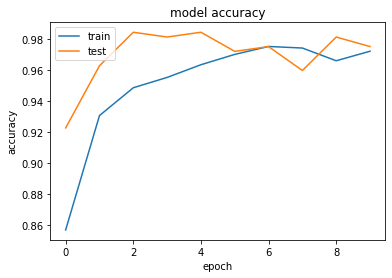

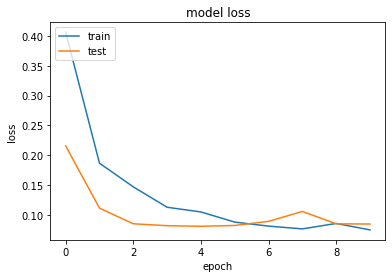

In [11]:
#Plotting the accuracy and loss
# summarize history for accuracy  
  

plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()
 
 # summarize history for loss  
  

plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [12]:
test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical", shuffle = False
)

Found 18 images belonging to 4 classes.


In [13]:
#Model evaluation
model1.evaluate_generator(generator=test_generator,
steps=len(test_generator))

#The test accuracy is 1.0 which is so far the highest acccuracy for cotton leaf classification

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.013833422213792801, 1.0]

In [14]:
test_generator.reset()
pred=model1.predict_generator(test_generator,steps=len(test_generator),
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
1/1 [==============================] - 0s 21ms/step


In [15]:
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [16]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['diseased cotton leaf',
 'diseased cotton leaf',
 'diseased cotton leaf',
 'diseased cotton plant',
 'diseased cotton plant',
 'diseased cotton plant',
 'diseased cotton plant',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton leaf',
 'fresh cotton leaf',
 'fresh cotton leaf',
 'fresh cotton leaf',
 'fresh cotton plant',
 'fresh cotton plant',
 'fresh cotton plant',
 'fresh cotton plant',
 'fresh cotton plant']

In [17]:
#Saving the model
#model1.save("cotton_incv3.h5")

In [18]:
#Loading the saved model
#model1 = load_model("cotton_incv3.h5")

In [19]:
filenames = test_generator.filenames

In [42]:
img = image.load_img('/content/drive/My Drive/data/train/fresh cotton plant/dsd (175)_iaip.jpg',target_size=(224,224))

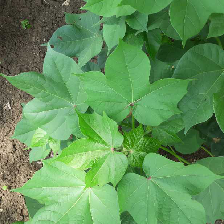

In [43]:
img

In [44]:
img = image.img_to_array(img)/255
img.shape

(224, 224, 3)

In [45]:
img_data=np.expand_dims(img,axis=0)
img_data.shape

(1, 224, 224, 3)

In [46]:
pred = model1.predict_generator(img_data)
pred

array([[2.1973572e-04, 1.3657826e-03, 2.1417667e-04, 9.9820030e-01]],
      dtype=float32)

In [47]:
label = np.argmax(pred,axis=1)
label[0]

3